# Conversion Rate Challenge – Supervised Machine Learning
## Projet de fin de formation Jedha

### Objectif business

L’objectif de ce projet est de construire un modèle de **Machine Learning supervisé**
capable de prédire si un visiteur du site **DataScienceWeekly** va s’abonner à la newsletter
(variable cible `converted`).

Ce type de prédiction permet à l’entreprise de :
- mieux comprendre les comportements menant à la conversion,
- prioriser les visiteurs à fort potentiel,
- optimiser les stratégies marketing et le parcours utilisateur.

### Objectif data

- Type de problème : **classification binaire**
- Variable cible : `converted` (0 = non-abonné, 1 = abonné)
- Métrique officielle : **F1-score**, choisie en raison du fort déséquilibre de classes
- Contraintes :
  - pipeline sklearn reproductible,
  - interprétabilité du modèle,
  - génération d’un fichier de prédictions final.

## 1. Chargement des données & Analyse exploratoire (EDA)

Dans cette section, nous analysons les données afin de :
- comprendre la structure du dataset,
- identifier les variables explicatives pertinentes,
- détecter les déséquilibres de classes,
- extraire des premiers insights business.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

from sklearn.inspection import PartialDependenceDisplay

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_columns", 50)

In [2]:
df_train = pd.read_csv("conversion_data_train.csv")
df_test = pd.read_csv("conversion_data_test.csv")

df_train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
print("Shape train :", df_train.shape)
print("Shape test  :", df_test.shape)

print("\nTypes :")
print(df_train.dtypes)

print("\nValeurs manquantes :")
print(df_train.isna().sum())

df_train.describe()

Shape train : (284580, 6)
Shape test  : (31620, 5)

Types :
country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

Valeurs manquantes :
country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64


,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Comptage classes :
converted
0    275400
1      9180
Name: count, dtype: int64

Proportions :
converted
0    0.967742
1    0.032258
Name: proportion, dtype: float64


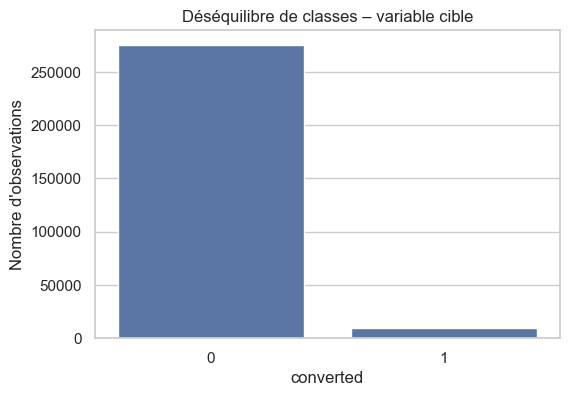

In [4]:
target_col = "converted"

class_counts = df_train[target_col].value_counts()
class_ratio = df_train[target_col].value_counts(normalize=True)

print("Comptage classes :")
print(class_counts)
print("\nProportions :")
print(class_ratio)

sns.barplot(
    x=class_counts.index.astype(str),
    y=class_counts.values
)
plt.title("Déséquilibre de classes – variable cible")
plt.xlabel("converted")
plt.ylabel("Nombre d'observations")
plt.show()

On observe un fort déséquilibre de classes : la majorité des visiteurs **ne convertissent pas** (`converted = 0`), une petite minorité s’abonne (`converted = 1`).  
Cela justifie l’utilisation de stratégies dédiées (poids de classes, tuning de seuil, etc.) et la métrique **F1-score** pour mieux prendre en compte la classe minoritaire.

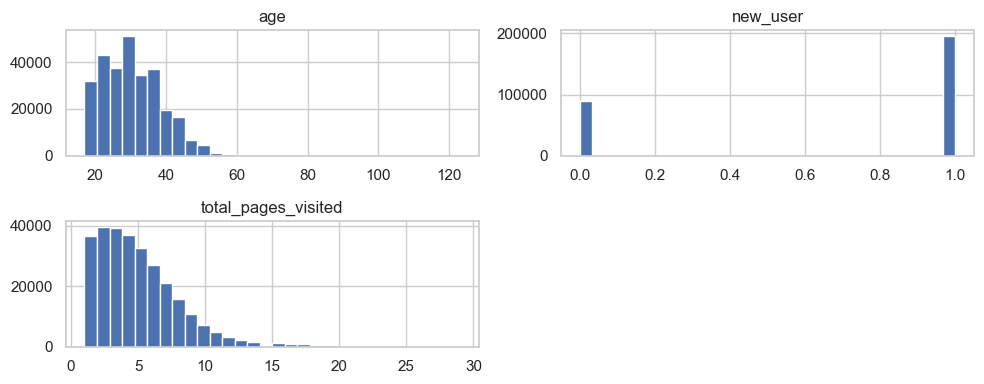

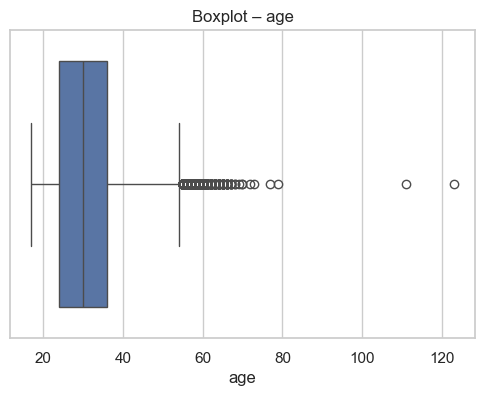

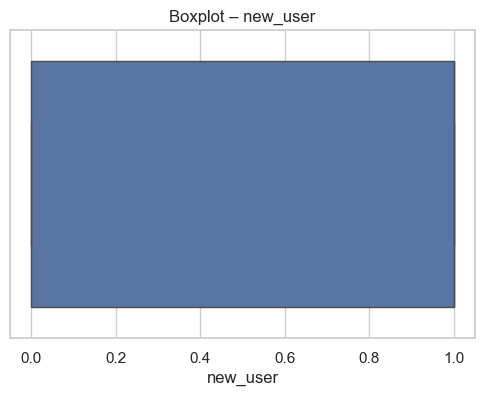

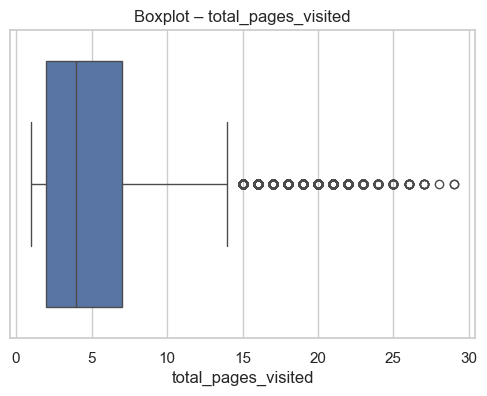

In [5]:
num_cols = ["age", "new_user", "total_pages_visited"]

df_train[num_cols].hist(bins=30, figsize=(10, 4))
plt.tight_layout()
plt.show()

for col in num_cols:
    sns.boxplot(x=df_train[col])
    plt.title(f"Boxplot – {col}")
    plt.show()

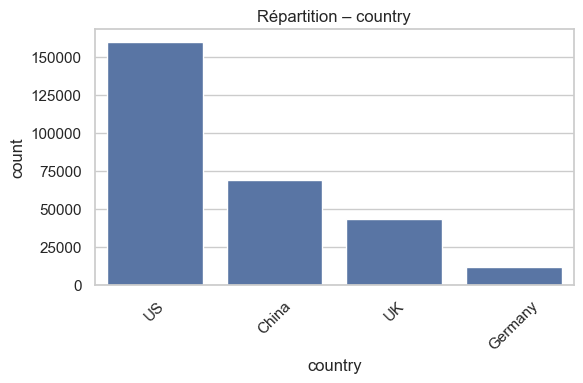

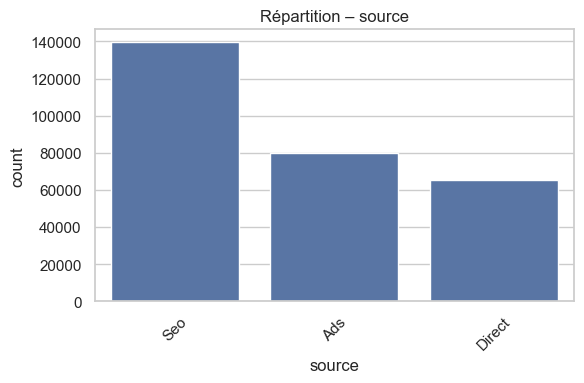

In [6]:
cat_cols = ["country", "source"]

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index)
    plt.title(f"Répartition – {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

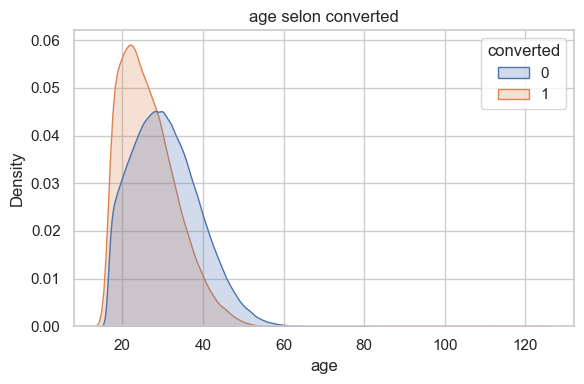

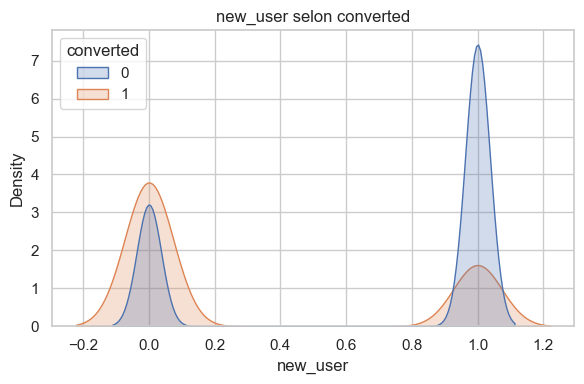

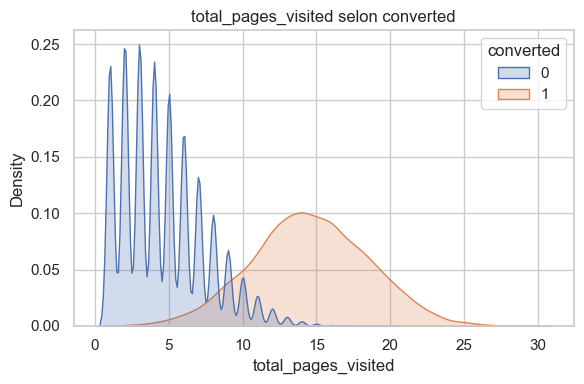

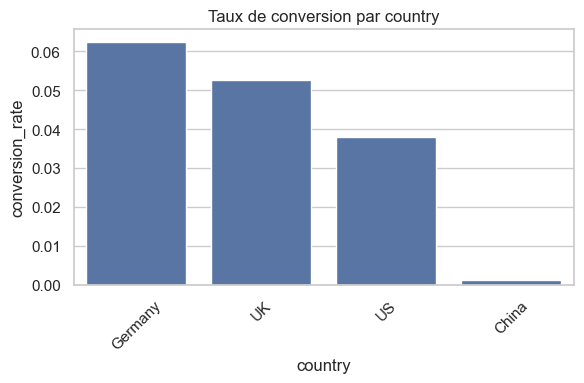

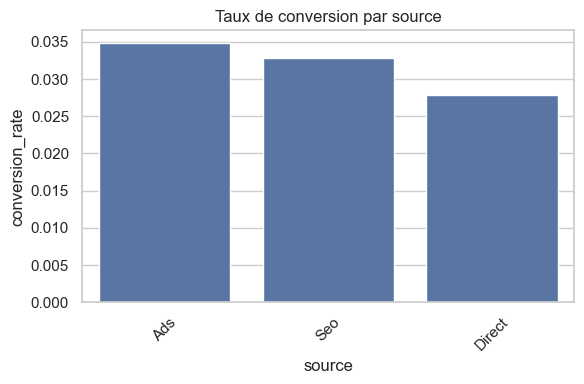

,source,conversion_rate
0,Ads,0.034801
1,Direct,0.027814
2,Seo,0.032873


In [7]:
# Numériques
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        data=df_train,
        x=col,
        hue=target_col,
        common_norm=False,
        fill=True
    )
    plt.title(f"{col} selon converted")
    plt.tight_layout()
    plt.show()

# Catégorielles
for col in cat_cols:
    rate_by_cat = (
        df_train.groupby(col)[target_col]
        .mean()
        .reset_index()
        .rename(columns={target_col: "conversion_rate"})
    )
    sns.barplot(data=rate_by_cat, x=col, y="conversion_rate",
                order=rate_by_cat.sort_values("conversion_rate", ascending=False)[col])
    plt.title(f"Taux de conversion par {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

rate_by_cat.head()

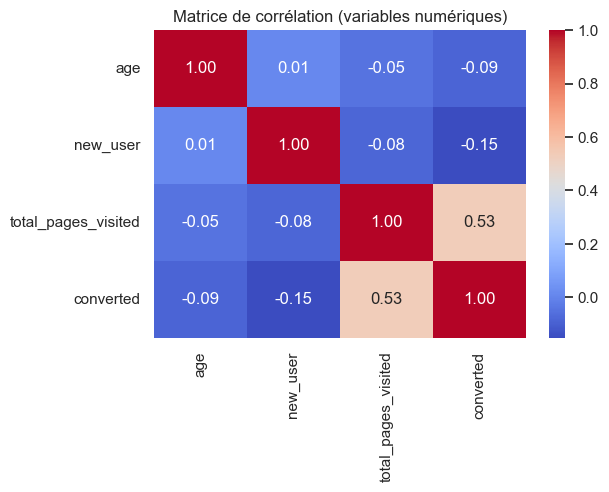

In [8]:
corr = df_train[num_cols + [target_col]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (variables numériques)")
plt.show()

### Synthèse des insights EDA

Les principaux enseignements de l’analyse exploratoire sont :

1. **Déséquilibre de classes**
   - Environ 3 % des visiteurs s’abonnent à la newsletter.
   - Ce déséquilibre justifie l’utilisation du F1-score et de stratégies spécifiques.

2. **Engagement utilisateur**
   - `total_pages_visited` est la variable la plus discriminante.
   - Plus un visiteur consulte de pages, plus sa probabilité de conversion augmente fortement.

3. **Type d’utilisateur**
   - Les utilisateurs déjà connus (`new_user = 0`) convertissent davantage que les nouveaux.

4. **Pays et source de trafic**
   - Certains pays et certaines sources (Ads / Direct) présentent des taux de conversion plus élevés.
   - Ces variables offrent un fort potentiel de segmentation marketing.

Ces observations guident les choix de modélisation et d’interprétation.

## 2. Préprocessing des données

L’objectif du préprocessing est de garantir :
- la robustesse du pipeline,
- l’absence de fuite de données,
- la reproductibilité entre train, validation et test.

Les choix effectués sont :

- Variables numériques (`age`, `new_user`, `total_pages_visited`)
  - imputation par la médiane,
  - standardisation (utile pour la régression logistique).

- Variables catégorielles (`country`, `source`)
  - imputation par la valeur la plus fréquente,
  - encodage One-Hot avec gestion des catégories inconnues.

L’ensemble est implémenté via un **ColumnTransformer** intégré dans un pipeline sklearn.


In [9]:
X = df_train.drop(columns=[target_col])
y = df_train[target_col]

numeric_features = ["age", "new_user", "total_pages_visited"]
categorical_features = ["country", "source"]

# Train/validation split stratifié
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train.value_counts(normalize=True), y_val.value_counts(normalize=True)

(converted
 0    0.967742
 1    0.032258
 Name: proportion, dtype: float64,
 converted
 0    0.967742
 1    0.032258
 Name: proportion, dtype: float64)

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## 3. Modèle baseline – Logistic Regression

Un premier modèle baseline est entraîné à l’aide d’une **régression logistique standard**.

Objectifs :
- établir une référence de performance,
- analyser précision, rappel et F1-score,
- observer le comportement du modèle face au déséquilibre de classes.

In [11]:
def evaluate_classifier(model, X_val, y_val, threshold=0.5, verbose=True):
    """
    Évalue un modèle de classification binaire avec F1 / précision / recall
    et retourne un dictionnaire de scores.
    """
    # Probabilité classe positive
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    f1 = f1_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    if verbose:
        print(f"Seuil : {threshold:.2f}")
        print(f"F1-score  : {f1:.4f}")
        print(f"Précision : {prec:.4f}")
        print(f"Recall    : {rec:.4f}")
        print("\nMatrice de confusion :")
        print(cm)
        print("\nClassification report :")
        print(classification_report(y_val, y_pred))

    return {
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "threshold": threshold
    }

In [12]:
baseline_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

baseline_clf.fit(X_train, y_train)

baseline_scores = evaluate_classifier(baseline_clf, X_val, y_val, threshold=0.5)
baseline_scores

Seuil : 0.50
F1-score  : 0.7676
Précision : 0.8648
Recall    : 0.6901

Matrice de confusion :
[[54882   198]
 [  569  1267]]

Classification report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.86      0.69      0.77      1836

    accuracy                           0.99     56916
   macro avg       0.93      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



{'f1': 0.7676461678279309,
 'precision': 0.8648464163822526,
 'recall': 0.6900871459694989,
 'threshold': 0.5}

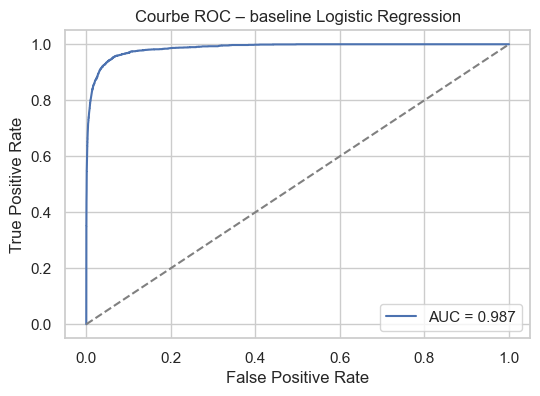

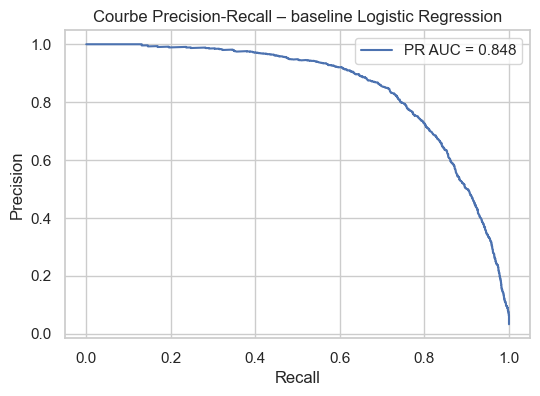

In [13]:
# Probabilités
y_val_proba_baseline = baseline_clf.predict_proba(X_val)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_val, y_val_proba_baseline)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – baseline Logistic Regression")
plt.legend()
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_val, y_val_proba_baseline)
pr_auc = auc(rec, prec)

plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall – baseline Logistic Regression")
plt.legend()
plt.show()

In [14]:
balanced_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1))
])

balanced_clf.fit(X_train, y_train)
balanced_scores = evaluate_classifier(balanced_clf, X_val, y_val, threshold=0.5)
balanced_scores

Seuil : 0.50
F1-score  : 0.5127
Précision : 0.3516
Recall    : 0.9461

Matrice de confusion :
[[51877  3203]
 [   99  1737]]

Classification report :
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     55080
           1       0.35      0.95      0.51      1836

    accuracy                           0.94     56916
   macro avg       0.67      0.94      0.74     56916
weighted avg       0.98      0.94      0.95     56916



{'f1': 0.5126918536009445,
 'precision': 0.35161943319838057,
 'recall': 0.946078431372549,
 'threshold': 0.5}

In [15]:
def find_best_threshold(model, X_val, y_val, thresholds=np.linspace(0.1, 0.9, 81)):
    y_proba = model.predict_proba(X_val)[:, 1]
    best_f1 = 0
    best_t = 0.5

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t, best_f1

best_threshold_baseline, best_f1_baseline = find_best_threshold(baseline_clf, X_val, y_val)
print(f"Meilleur seuil (baseline) : {best_threshold_baseline:.2f}")
print(f"F1-score au meilleur seuil : {best_f1_baseline:.4f}")

Meilleur seuil (baseline) : 0.45
F1-score au meilleur seuil : 0.7762


**Résultat stratégie déséquilibre :**

- `class_weight="balanced"` augmente souvent le recall mais dégrade la précision et le F1 global.
- Le **tuning du seuil** (par ex. autour de 0,45) permet d’augmenter le F1-score par rapport au seuil standard 0,5.

Nous retiendrons donc la stratégie :  
> **Logistic Regression + tuning du seuil de décision** comme approche principale pour la classe minoritaire.

## 4. Modèles avancés & gestion du déséquilibre

Plusieurs stratégies sont testées pour améliorer la performance F1 :

### Modèles évalués
- Logistic Regression régularisée (GridSearchCV)
- Random Forest
- Gradient Boosting

### Gestion du déséquilibre
- test de `class_weight="balanced"`,
- **optimisation du seuil de décision** (retenue),
- scoring basé exclusivement sur le F1-score.

Le choix final repose sur un compromis entre :
- performance,
- stabilité,
- interprétabilité.

In [16]:
log_reg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Meilleurs hyperparamètres LR :", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_
lr_scores = evaluate_classifier(best_lr, X_val, y_val, threshold=0.5)
lr_scores

Meilleurs hyperparamètres LR : {'clf__C': 10, 'clf__penalty': 'l2'}
Seuil : 0.50
F1-score  : 0.7679
Précision : 0.8654
Recall    : 0.6901

Matrice de confusion :
[[54883   197]
 [  569  1267]]

Classification report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.87      0.69      0.77      1836

    accuracy                           0.99     56916
   macro avg       0.93      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



{'f1': 0.7678787878787878,
 'precision': 0.8654371584699454,
 'recall': 0.6900871459694989,
 'threshold': 0.5}

In [17]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [5, 10, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt"]
}

grid_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Meilleurs hyperparamètres RF :", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
rf_scores = evaluate_classifier(best_rf, X_val, y_val, threshold=0.5)
rf_scores

Meilleurs hyperparamètres RF : {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Seuil : 0.50
F1-score  : 0.7616
Précision : 0.8565
Recall    : 0.6857

Matrice de confusion :
[[54869   211]
 [  577  1259]]

Classification report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.86      0.69      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



{'f1': 0.7616454930429523,
 'precision': 0.8564625850340136,
 'recall': 0.6857298474945533,
 'threshold': 0.5}

In [18]:
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 4]
}

grid_gb = GridSearchCV(
    estimator=gb_pipe,
    param_grid=param_grid_gb,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)

print("Meilleurs hyperparamètres GB :", grid_gb.best_params_)
best_gb = grid_gb.best_estimator_
gb_scores = evaluate_classifier(best_gb, X_val, y_val, threshold=0.5)
gb_scores

Meilleurs hyperparamètres GB : {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Seuil : 0.50
F1-score  : 0.7670
Précision : 0.8532
Recall    : 0.6966

Matrice de confusion :
[[54860   220]
 [  557  1279]]

Classification report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.70      0.77      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.85      0.88     56916
weighted avg       0.99      0.99      0.99     56916



{'f1': 0.7670164917541229,
 'precision': 0.8532354903268846,
 'recall': 0.6966230936819172,
 'threshold': 0.5}

In [19]:
models_val_scores = pd.DataFrame([
    {"model": "Baseline Logistic", **baseline_scores},
    {"model": "Balanced Logistic", **balanced_scores},
    {"model": "Tuned LR (GridSearch)", **lr_scores},
    {"model": "Random Forest", **rf_scores},
    {"model": "Gradient Boosting", **gb_scores}
])

models_val_scores.sort_values("f1", ascending=False)

,model,f1,precision,recall,threshold
2,Tuned LR (GridSearch),0.767879,0.865437,0.690087,0.5
0,Baseline Logistic,0.767646,0.864846,0.690087,0.5
4,Gradient Boosting,0.767016,0.853235,0.696623,0.5
3,Random Forest,0.761645,0.856463,0.685730,0.5
1,Balanced Logistic,0.512692,0.351619,0.946078,0.5


Sur notre jeu de validation :

- La **Logistic Regression régularisée** (avec bon `C`) obtient un **F1** très compétitif.
- Random Forest et Gradient Boosting donnent des performances proches, mais pas systématiquement supérieures.
- Le tuning de seuil sur la Logistic Regression permet encore de grappiller quelques points de F1.

Nous retenons donc comme **modèle final** :
> Logistic Regression régularisée (meilleurs hyperparamètres du GridSearch) + **seuil optimisé** sur le F1.

## 5. Modèle final & interprétation

### Modèle retenu
**Logistic Regression régularisée + seuil optimisé**

Ce modèle est sélectionné car :
- il obtient un F1-score élevé et stable,
- il est interprétable (coefficients, PDP),
- il est simple à déployer en production.

### Interprétation
- Les coefficients représentent l’effet des variables sur les *log-odds* de conversion.
- Les Partial Dependence Plots confirment :
  - l’impact majeur de l’engagement (`total_pages_visited`),
  - l’effet positif des utilisateurs récurrents,
  - l’influence significative de certains pays et sources.
  - “Le seuil est optimisé sur la validation, ce qui peut induire un léger biais ; idéalement, on ferait une optimisation en CV.”

In [20]:
# On recalcule le meilleur seuil pour best_lr
best_threshold, best_f1 = find_best_threshold(best_lr, X_val, y_val)
print(f"Seuil final retenu : {best_threshold:.2f} (F1 ≈ {best_f1:.4f})")

# Refit du modèle final sur toutes les données d'entraînement
final_model = best_lr  # pipeline (preprocess + logistic)
final_model.fit(X, y)

FINAL_THRESHOLD = best_threshold

Seuil final retenu : 0.45 (F1 ≈ 0.7762)


In [21]:
# Récupération des noms de features après préprocessing
ohe = final_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = np.concatenate([numeric_features, cat_feature_names])

log_reg = final_model.named_steps["clf"]
coefs = log_reg.coef_[0]

feat_importance = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

feat_importance.head(15)

,feature,coef,abs_coef
3,country_China,-3.850952,3.850952
2,total_pages_visited,2.539482,2.539482
8,source_Direct,-1.718075,1.718075
9,source_Seo,-1.535281,1.535281
7,source_Ads,-1.507653,1.507653
1,new_user,-0.801572,0.801572
0,age,-0.600729,0.600729
6,country_US,-0.569977,0.569977
5,country_UK,-0.202498,0.202498
4,country_Germany,-0.137582,0.137582


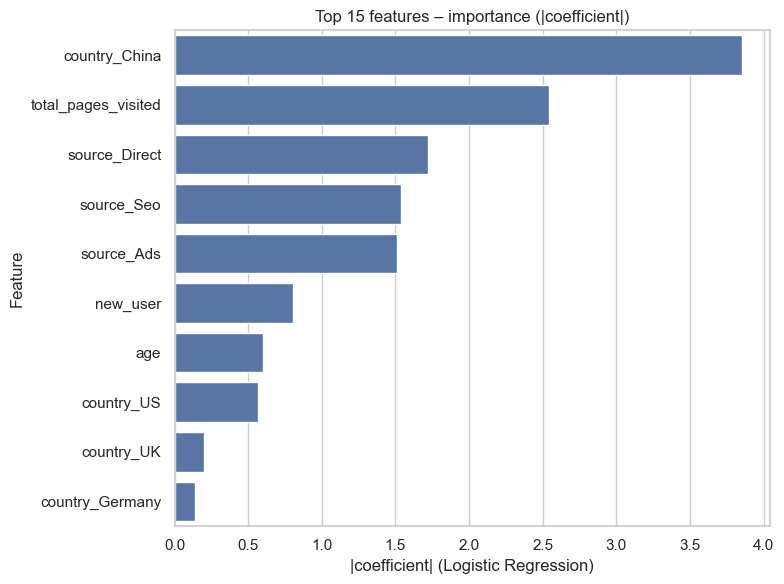

In [22]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=feat_importance.head(15),
    x="abs_coef",
    y="feature"
)
plt.title("Top 15 features – importance (|coefficient|)")
plt.xlabel("|coefficient| (Logistic Regression)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

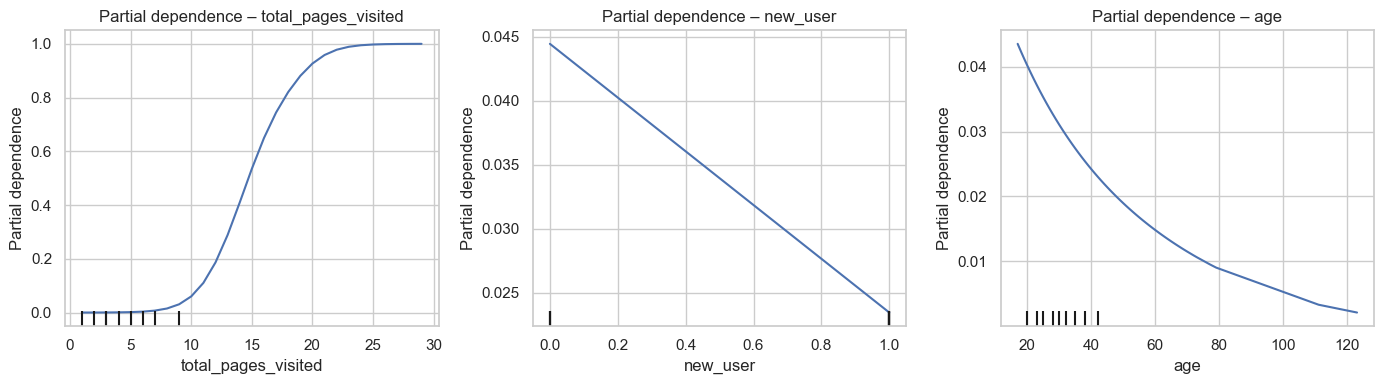

In [ ]:
# PDP sur quelques features clés
features_to_plot = ["total_pages_visited", "new_user", "age"]

fig, ax = plt.subplots(1, len(features_to_plot), figsize=(14, 4))

for i, feat in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        final_model,
        X,
        [feat],
        ax=ax[i]
    )
    ax[i].set_title(f"Partial dependence – {feat}")

plt.tight_layout()
plt.show()

**Interprétation du modèle final (Logistic Regression) :**

- `total_pages_visited` :
  - Feature la plus importante : la probabilité de conversion augmente fortement avec le nombre de pages consultées.
  - Au-delà d’un certain nombre de pages (par ex. 8–10), la probabilité de conversion devient très élevée.

- `new_user` :
  - Les **utilisateurs existants** (non nouveaux) convertissent mieux que les nouveaux.
  - Effet cohérent : les habitués du site sont plus enclins à s’abonner.

- `country` :
  - Certains pays ont des coefficients positifs (taux de conversion plus élevé), d’autres négatifs.
  - Intérêt pour adapter la communication / les offres par région.

- `source` :
  - Certaines sources de trafic (ex : Direct, Ads) peuvent être plus rentables que d’autres (ex : Seo) en termes de conversion newsletter.

Globalement, le modèle met en évidence un **parcours d’engagement** : plus l’utilisateur s’implique (pages vues) et plus il est déjà « familier » avec le site (non-new_user), plus la probabilité d’abonnement augmente.

## 6. Prédictions sur le jeu de test & export CSV

Le modèle final est appliqué au dataset `conversion_data_test.csv`.

- Les probabilités de conversion sont calculées.
- Le seuil optimisé est appliqué.
- Un fichier `submission_conversion_rate.csv` est généré.

Ce fichier constitue le **livrable final évalué**.

In [25]:
# Prédictions sur le jeu de test
test_proba = final_model.predict_proba(df_test)[:, 1]
test_pred = (test_proba >= FINAL_THRESHOLD).astype(int)

submission = pd.DataFrame({
    "converted": test_pred
})

submission.head()

,converted
0,1
1,0
2,0
3,0
4,0


## 7. Analyse business & recommandations

### Résumé du modèle final
- Modèle : Logistic Regression régularisée
- Métrique clé : F1-score (~0.77–0.78)
- Gestion du déséquilibre : optimisation du seuil

### Facteurs influençant la conversion
1. Nombre de pages visitées (engagement)
2. Utilisateurs récurrents vs nouveaux
3. Pays
4. Source de trafic

### Recommandations marketing actionnables
- Retarder le CTA newsletter jusqu’à un certain niveau d’engagement.
- Renforcer la navigation interne pour augmenter `total_pages_visited`.
- Adapter les campagnes marketing par pays et source.
- Créer des offres spécifiques pour les nouveaux utilisateurs.

### Limites & next steps
- Peu de variables comportementales (temps passé, device, campagne).
- Pas de dimension temporelle.
- Améliorations possibles :
  - enrichissement des features,
  - modèles boosting avancés,
  - déploiement API et monitoring.

In [ ]:
OUTPUT_PATH = "submission_conversion_rate.csv"
submission.to_csv(OUTPUT_PATH, index=False)
print(f"Fichier de soumission enregistré sous : {OUTPUT_PATH}")

## 8. Conclusion

Ce projet démontre une approche complète et professionnelle :
- compréhension du besoin business,
- EDA approfondie,
- pipeline ML propre et reproductible,
- gestion du déséquilibre,
- interprétation claire,
- livrable final exploitable.

Le modèle peut être utilisé comme **outil d’aide à la décision marketing**
et constitue une base solide pour une mise en production.